### conda env: **cv-proj**

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [1]:
import os
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval

import astroscrappy
import matplotlib.pyplot as plt
import glob


In [2]:
bias_files = ['d4000.fits', 'd4001.fits', 'd4002.fits', 'd4003.fits', 'd4004.fits', 'd4005.fits', 'd4006.fits', 'd4007.fits', 'd4008.fits', 'd4009.fits', 'd4010.fits', 'd4011.fits', 'd4012.fits', 'd4013.fits', 'd4014.fits']
data_dir = 'data/nickel_raw'

print('Bias file count: ', len(bias_files))

# Read all bias frames into a list
bias_frames = [fits.getdata(os.path.join(data_dir, file)) for file in bias_files]

# Stack the bias frames into a 3D array (shape: num_frames, height, width)
bias_stack = np.stack(bias_frames, axis=0)

# Compute the median across the stack (median-combine)
master_bias = np.median(bias_stack, axis=0)

# Save the master bias frame to a new FITS file
hdu = fits.PrimaryHDU(master_bias)
hdu.writeto('../data/bias/master_bias.fits', overwrite=True)

print("Master bias frame created and saved as 'master_bias.fits'.")

Bias file count:  15


FileNotFoundError: [Errno 2] No such file or directory: 'data/nickel_raw/d4000.fits'

In [18]:
# First image in each set: assuming no filter

# Load flat field images using astropy
# Convert fl1ats to CCDData objects for easier manipulation
flat_30 = fits.getdata('../data/nickel_raw/flat_files/dome_flat_30/d4015.fits')
flat_4 = fits.getdata('../data/nickel_raw/flat_files/dome_flat_4/d4020.fits')
flat_5 = fits.getdata('../data/nickel_raw/flat_files/dome_flat_5/d4025.fits')
flat_3_5 = fits.getdata('../data/nickel_raw/flat_files/dome_flat_3p5/d4030.fits')

# Subtract the master bias from each flat field
flat_30_bias_subtracted = flat_30 - master_bias
flat_4_bias_subtracted = flat_4 - master_bias
flat_5_bias_subtracted = flat_5 - master_bias
flat_3_5_bias_subtracted = flat_3_5 - master_bias

# Normalize the bias-subtracted flat fields
flat_30_normalized = flat_30_bias_subtracted / np.median(flat_30_bias_subtracted)
flat_4_normalized = flat_4_bias_subtracted / np.median(flat_4_bias_subtracted)
flat_5_normalized = flat_5_bias_subtracted / np.median(flat_5_bias_subtracted)
flat_3_5_normalized = flat_3_5_bias_subtracted / np.median(flat_3_5_bias_subtracted)



In [5]:
from astropy.io import fits
from astropy.nddata import CCDData
import numpy as np
from scipy.optimize import curve_fit

def create_synthetic_flat(flat_files, exposure_times, master_bias_file, target_exposure_time, output_file=None):
    """
    Create a synthetic flat field for a given target exposure time by fitting a model 
    to flat fields taken with varying exposure times.
    
    Parameters:
    -----------
    flat_files : list of str
        List of file paths to the flat field FITS files.
    
    exposure_times : list of float
        List of exposure times corresponding to each flat file.
        
    master_bias_file : str
        File path to the master bias FITS file.
    
    target_exposure_time : float
        The exposure time for which the synthetic flat is needed.
    
    output_file : str or None
        File path to save the synthetic flat field FITS file. If None, no file is saved.
    
    Returns:
    --------
    synthetic_flat : np.ndarray
        The synthetic flat field corresponding to the target exposure time.
    """
    
    # Load the master bias file
    master_bias = fits.getdata(master_bias_file)
    # master_bias_ccd = CCDData(master_bias, unit='adu')

    # Initialize a list to store bias-subtracted, normalized flat fields
    normalized_flats = []

    # Loop over flat files and subtract bias and normalize each flat
    for flat_file in flat_files:
        # Load the flat field
        flat_data = fits.getdata(flat_file)
        # flat_ccd = CCDData(flat_data, unit='adu')
        
        # Subtract the master bias
        flat_bias_subtracted = flat_data - master_bias
        
        # Normalize the flat by its median
        flat_normalized = flat_bias_subtracted / np.median(flat_bias_subtracted)
        
        # Append the normalized flat to the list
        normalized_flats.append(flat_normalized)
    
    # Stack normalized flats into a 3D array (num_flats, height, width)
    flats_stack = np.stack(normalized_flats, axis=0)
    
    # Prepare an array to store the synthetic flat for the target exposure time
    synthetic_flat = np.zeros_like(normalized_flats[0])
    
    # Define a linear model for fitting (can be replaced with more complex models if needed)
    def linear_model(exposure, a, b):
        return a * exposure + b

    # Fit the model for each pixel and generate the synthetic flat
    for i in range(synthetic_flat.shape[0]):
        for j in range(synthetic_flat.shape[1]):
            # Get the pixel values across the normalized flats
            pixel_values = flats_stack[:, i, j]
            
            # Fit the linear model to the pixel values
            popt, _ = curve_fit(linear_model, exposure_times, pixel_values)
            
            # Use the fitted model to predict the flat field value at the target exposure time
            synthetic_flat[i, j] = linear_model(target_exposure_time, *popt)
    
    # Optionally, save the synthetic flat to a FITS file
    if output_file:
        hdu = fits.PrimaryHDU(synthetic_flat)
        hdu.writeto(output_file, overwrite=True)
    
    return synthetic_flat



In [6]:
from utils.raw_filenames import filename_d

In [56]:
os.path.join(processed_data_dir, 'bias/master_bias.fits')

'data/processed/bias/master_bias.fits'

In [53]:
processed_data_dir = 'data/processed'
target_exposure_time = 30
filter_num=1
os.path.join(processed_data_dir, 'flat/master_flat_filter_'+str(filter_num)+'_'+str(target_exposure_time)+'s', '.fits')

'data/processed/flat/master_flat_filter_1_30s/.fits'

In [54]:

for filter_num in np.arange(0,5):
    flat_filenames = [exp_t_l[filter_num] for exp_t_l in filename_d['flat'].values()]
    raw_data_dir = 'data/raw'
    processed_data_dir = 'data/processed'

    # Read all flat frames into a list
    flat_frame_filepath_l = [os.path.join(raw_data_dir, filename) for filename in flat_filenames]

    # Get the exposure time for each target image
    target_exposure_time = list(filename_d['target'].values())[0][filter_num]['exposure_time']

    output_filename = os.path.join(processed_data_dir, 'flat/master_flat_filter_'+str(filter_num)+'_'+str(target_exposure_time)+'s', '.fits')

    create_synthetic_flat(flat_files=flat_frame_filepath_l,
                          exposure_times=[30, 5, 4, 3.5],
                          master_bias_file='../data/processed/bias/master_bias.fits',
                          target_exposure_time=target_exposure_time,
                          output_file=output_filename)

FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/d4015.fits'

In [37]:
list(filename_d['target'].values())[0][0]['exposure_time']

30

In [25]:
flat_frames

['data/raw/d4015.fits',
 'data/raw/d4025.fits',
 'data/raw/d4020.fits',
 'data/raw/d4030.fits']

In [25]:

no_filter_flat_path_l = [exp_t_l[0] for exp_t_l in filename_d['flat'].values()]


# Assuming the first file in the AY_psc data files is the no filter image, the no filter exposure time was 30s.
target_exposure_time = 30
output_filename = '../data/flat/master_flat_no_filter_' + str(target_exposure_time) + '.fits'
create_synthetic_flat(flat_files=no_filter_flat_path_l,
                    exposure_times=[30, 4, 5, 3.5],
                    master_bias_file='../data/bias/master_bias.fits',
                    target_exposure_time=target_exposure_time,
                    output_file=output_filename)

array([[ 1.46197138e-02,  1.05175093e-02,  1.35566022e-02, ...,
         6.96636626e-04,  5.21389714e-04,  1.75592108e-04],
       [ 3.96041472e-02,  2.18727681e-02,  2.47069072e-02, ...,
         8.11083115e-04,  9.39304489e-04,  7.37093834e-04],
       [ 4.59151968e-02,  2.55272612e-02,  2.78770655e-02, ...,
         8.38948597e-04,  6.64549639e-04,  8.67764929e-04],
       ...,
       [ 1.94061471e-02,  8.28978610e-03,  8.69654836e-03, ...,
         6.83773003e-05,  1.88703838e-04,  2.04869787e-04],
       [ 1.78799038e-02,  9.06757339e-03,  7.88941967e-03, ...,
        -3.18404895e-05,  1.90005506e-04, -1.04477662e-04],
       [ 2.07741057e-02,  9.95294948e-03,  8.73870349e-03, ...,
        -2.18332472e-04,  1.68057877e-04, -6.06161002e-05]])

In [ ]:
image_file, master_bias_file, master_flat_file, output_filename

In [60]:
raw_data_dir = 'data/raw'

In [67]:
synth_flat_filename_l = [
    'flat/master_flat_filter_0_30s.fits',
    'flat/master_flat_filter_1_180s.fits',
    'flat/master_flat_filter_2_120s.fits',
    'flat/master_flat_filter_3_60s.fits',
    'flat/master_flat_filter_4_60s.fits',
]

In [65]:
for target_num in np.arange(0,len(list(filename_d['target'].values())[0])):
    target_d = list(filename_d['target'].values())[0][target_num]
    print( {
        'target_filename': os.path.join(raw_data_dir, target_d['filename']),
        'master_bias_file': os.path.join(processed_data_dir, 'bias/master_bias.fits'),
        'synth_flat_file': synth_flat_filename_l[target_num]
    })

5

In [64]:
for target_d in list(filename_d['target'].values())[0]:
    print( {
        'target_filename': os.path.join(raw_data_dir, target_d['filename']),
        'master_bias_file': os.path.join(processed_data_dir, 'bias/master_bias.fits'),
        'synth_flat_file'
    })

{'target_filename': 'data/raw/d4082.fits'}
{'target_filename': 'data/raw/d4083.fits'}
{'target_filename': 'data/raw/d4084.fits'}
{'target_filename': 'data/raw/d4085.fits'}
{'target_filename': 'data/raw/d4086.fits'}


In [26]:
import numpy as np
from astropy.io import fits

# Define a function to reduce a single science image
def reduce_science_image(image_file, master_bias_file, master_flat_file, output_filename):
    # Load the raw science image
    science_image, science_header = fits.getdata(image_file, header=True)
    
    # Load the master bias
    master_bias = fits.getdata(master_bias_file)
    
    # Load the master flat
    master_flat = fits.getdata(master_flat_file)
    
    # Step 1: Bias Subtraction
    bias_subtracted_image = science_image - master_bias
    
    # Step 2: Flat-Field Correction (divide by the normalized flat field)
    flat_corrected_image = bias_subtracted_image / master_flat
    
    # Save the reduced science image
    fits.writeto(output_filename, flat_corrected_image, science_header, overwrite=True)
    print(f"Reduced image saved as {output_filename}")

In [27]:
image_name_l = ['d4082']

for image_name in image_name_l:
    reduce_science_image(image_file=f'../data/nickel_raw/ay_psc/{image_name}.fits',
                        master_bias_file='../data/bias/master_bias.fits',
                        master_flat_file='../data/flat/master_flat_no_filter_30.fits',
                        output_filename=f'../data/reduced/{image_name}.fits')


Reduced image saved as ../data/reduced/d4082.fits


In [29]:
def sexagesimal_to_decimal(ra, dec):
    # Convert RA from 'hh:mm:ss' to decimal degrees
    ra_hours, ra_minutes, ra_seconds = map(float, ra.split(':'))
    ra_degrees = 15 * (ra_hours + ra_minutes / 60 + ra_seconds / 3600)
    
    # Convert DEC from 'dd:mm:ss' to decimal degrees
    dec_sign = -1 if dec[0] == '-' else 1
    dec_degrees = dec_sign * (abs(float(dec[:-1].split(':')[0])) + 
                               float(dec[:-1].split(':')[1]) / 60 + 
                               float(dec[:-1].split(':')[2]) / 3600)
    return ra_degrees, dec_degrees

# Define the coordinates of the object of interest (RA, DEC)
ra_object = '01:36:55.46'  # Right Ascension
dec_object = '+07:16:29.3'  # Declination

# Convert RA and DEC to decimal degrees
ra_dec = sexagesimal_to_decimal(ra_object, dec_object)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 60581.411662 from DATE-END'. [astropy.wcs.wcs]


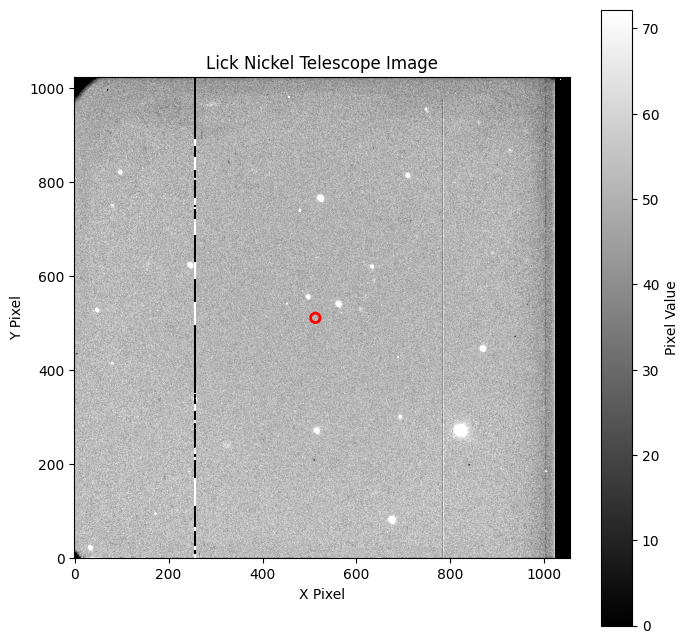

In [30]:

# Load the image data from the FITS file
image_data, header = fits.getdata('../data/reduced/d4082.fits', header=True)

# Create a WCS object
wcs = WCS(header)


# Step 3: Define the coordinates of the object of interest (RA, DEC)
ra_object = '01:36:55.46'  # Right Ascension
dec_object = '+07:16:29.3'  # Declination

# Convert celestial coordinates to pixel coordinates
x_object, y_object = wcs.all_world2pix(ra_dec[0], ra_dec[1], 0)  # 0 for the first frame


# Create a basic image plot
plt.figure(figsize=(8, 8))
plt.imshow(image_data, cmap='gray', origin='lower', vmin=0, vmax=np.percentile(image_data, 99))
# Plot the thin red circle
circle_radius = 10  # Adjust the radius for the circle
circle = plt.Circle((x_object, y_object), circle_radius, color='red', fill=False, linewidth=2)
plt.gca().add_artist(circle)
plt.colorbar(label='Pixel Value')
plt.title('Lick Nickel Telescope Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()


In [ ]:
# Now, looking at the first filter (B?)
filter_name = 'b'
filter_number_delta = 1
flat_path_l = [f'../data/nickel_raw/flat_files/dome_flat_30/d40'+{str(15+filter_number_delta)}+'.fits',
                          '../data/nickel_raw/flat_files/dome_flat_4/d40'+{str(20+filter_number_delta)}+'.fits',
                          '../data/nickel_raw/flat_files/dome_flat_5/d40'+{str(25+filter_number_delta)}+'.fits',
                          '../data/nickel_raw/flat_files/dome_flat_3p5/d40'+{str(30+filter_number_delta)}+'.fits']

# Assuming the second file in the AY_psc data files is the B filter image, the no filter exposure time was 180s.
target_exposure_time = 180
output_filename = '../data/flat/master_flat_b_filter_' + str(target_exposure_time) + '.fits'
create_synthetic_flat(flat_files=no_filter_flat_path_l,
                    exposure_times=[30, 4, 5, 3.5],
                    master_bias_file='../data/flat/master_bias.fits',
                    target_exposure_time=target_exposure_time,
                    output_file=output_filename)



# Now, looking at the second filter (V?)
filter_name = 'v'
filter_number_delta = 2
flat_path_l = [f'../data/nickel_raw/flat_files/dome_flat_30/d40'+{str(15+filter_number_delta)}+'.fits',
                          '../data/nickel_raw/flat_files/dome_flat_4/d40'+{str(20+filter_number_delta)}+'.fits',
                          '../data/nickel_raw/flat_files/dome_flat_5/d40'+{str(25+filter_number_delta)}+'.fits',
                          '../data/nickel_raw/flat_files/dome_flat_3p5/d40'+{str(30+filter_number_delta)}+'.fits']

# Assuming the second file in the AY_psc data files is the B filter image, the no filter exposure time was 180s.
target_exposure_time = 120
output_filename = f'../data/flat/master_flat_{filter_name}_filter_' + str(target_exposure_time) + '.fits'
create_synthetic_flat(flat_files=flat_path_l,
                    exposure_times=[30, 4, 5, 3.5],
                    master_bias_file='../data/flat/master_bias.fits',
                    target_exposure_time=target_exposure_time,
                    output_file=output_filename)



# Now, looking at the first filter (R?)
filter_name = 'r'
filter_number_delta = 3
flat_path_l = [f'../data/nickel_raw/flat_files/dome_flat_30/d40'+{str(15+filter_number_delta)}+'.fits',
                          '../data/nickel_raw/flat_files/dome_flat_4/d40'+{str(20+filter_number_delta)}+'.fits',
                          '../data/nickel_raw/flat_files/dome_flat_5/d40'+{str(25+filter_number_delta)}+'.fits',
                          '../data/nickel_raw/flat_files/dome_flat_3p5/d40'+{str(30+filter_number_delta)}+'.fits']

# Assuming the second file in the AY_psc data files is the B filter image, the no filter exposure time was 180s.
target_exposure_time = 60
output_filename = '../data/flat/master_flat_b_filter_' + str(target_exposure_time) + '.fits'
create_synthetic_flat(flat_files=no_filter_flat_path_l,
                    exposure_times=[30, 4, 5, 3.5],
                    master_bias_file='../data/flat/master_bias.fits',
                    target_exposure_time=target_exposure_time,
                    output_file=output_filename)



# Now, looking at the second filter (I?)
filter_name = 'i'
filter_number_delta = 4
flat_path_l = [f'../data/nickel_raw/flat_files/dome_flat_30/d40'+{str(15+filter_number_delta)}+'.fits',
                          '../data/nickel_raw/flat_files/dome_flat_4/d40'+{str(20+filter_number_delta)}+'.fits',
                          '../data/nickel_raw/flat_files/dome_flat_5/d40'+{str(25+filter_number_delta)}+'.fits',
                          '../data/nickel_raw/flat_files/dome_flat_3p5/d40'+{str(30+filter_number_delta)}+'.fits']

# Assuming the second file in the AY_psc data files is the B filter image, the no filter exposure time was 180s.
target_exposure_time = 60
output_filename = f'../data/flat/master_flat_{filter_name}_filter_' + str(target_exposure_time) + '.fits'
create_synthetic_flat(flat_files=flat_path_l,
                    exposure_times=[30, 4, 5, 3.5],
                    master_bias_file='../data/flat/master_bias.fits',
                    target_exposure_time=target_exposure_time,
                    output_file=output_filename)

In [ ]:
image_name_l = ['d4082', 'd4083', 'd4084', 'd4085', 'd4086']

for image_name in image_name_l:
    reduce_science_image(image_file=f'../data/nickel_raw/ay_psc/{image_name}.fits',
                        master_bias_file='../data/bias/master_bias.fits',
                        master_flat_file='../data/flat/master_flat_30s.fits',
                        output_filename=f'../data/reduced/{image_name}.fits')


In [78]:
import numpy as np
from astropy.io import fits
import glob

# Define a function to create a master flat for each set
def create_master_flat(flat_files, output_filename):
    # Read all flat frames into a list
    flat_frames = [fits.getdata(file) for file in flat_files]
    
    # Stack the flat frames into a 3D array (shape: num_frames, height, width)
    flat_stack = np.stack(flat_frames, axis=0)
    
    # Compute the median across the stack (median-combine)
    master_flat = np.median(flat_stack, axis=0)
    normalized_flat = master_flat / np.median(master_flat)

    # Save the master flat frame to a new FITS file
    hdu = fits.PrimaryHDU(normalized_flat)
    hdu.writeto(output_filename, overwrite=True)
    print(f"Normalized master flat saved as {output_filename}")

# Create master flats for each exposure time set
create_master_flat(glob.glob('../data/nickel_raw/flat_files/dome_flat_30/*.fits'), '../data/flat/master_flat_30s.fits')
create_master_flat(glob.glob('../data/nickel_raw/flat_files/dome_flat_4/*.fits'), '../data/flat/master_flat_4s.fits')
create_master_flat(glob.glob('../data/nickel_raw/flat_files/dome_flat_5/*.fits'), '../data/flat/master_flat_5s.fits')
create_master_flat(glob.glob('../data/nickel_raw/flat_files/dome_flat_3p5/*.fits'), '../data/flat/master_flat_3p5s.fits')


Normalized master flat saved as ../data/flat/master_flat_30s.fits
Normalized master flat saved as ../data/flat/master_flat_4s.fits
Normalized master flat saved as ../data/flat/master_flat_5s.fits
Normalized master flat saved as ../data/flat/master_flat_3p5s.fits


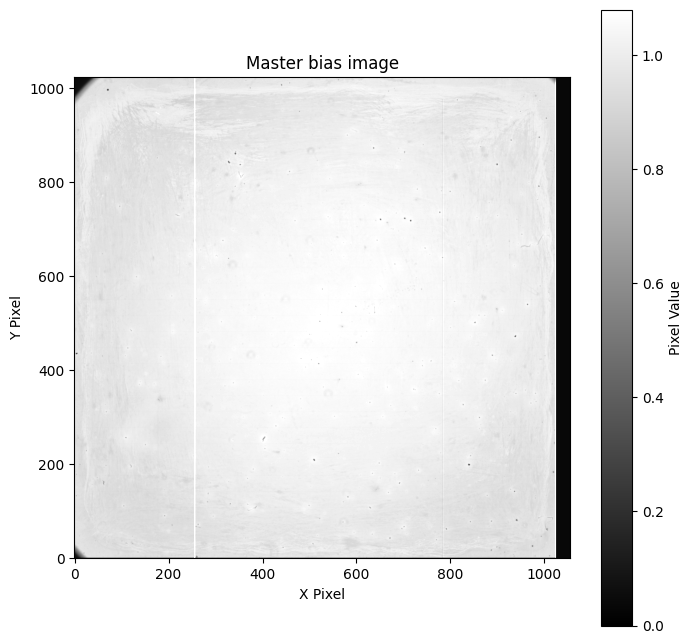

In [79]:
# Load the image data from the FITS file
image_data = fits.getdata('../data/flat/master_flat_30s.fits')

# Create a basic image plot
plt.figure(figsize=(8, 8))
plt.imshow(image_data, cmap='gray', origin='lower', vmin=0, vmax=np.percentile(image_data, 99))
plt.colorbar(label='Pixel Value')
plt.title('Master bias image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()


In [80]:
import numpy as np
from astropy.io import fits

# Define a function to reduce a single science image
def reduce_science_image(image_file, master_bias_file, master_flat_file, output_filename):
    # Load the raw science image
    science_image, science_header = fits.getdata(image_file, header=True)
    
    # Load the master bias
    master_bias = fits.getdata(master_bias_file)
    
    # Load the master flat
    master_flat = fits.getdata(master_flat_file)
    
    # Step 1: Bias Subtraction
    bias_subtracted_image = science_image - master_bias
    
    # Step 2: Flat-Field Correction (divide by the normalized flat field)
    flat_corrected_image = bias_subtracted_image / master_flat
    
    # Save the reduced science image
    fits.writeto(output_filename, flat_corrected_image, science_header, overwrite=True)
    print(f"Reduced image saved as {output_filename}")


In [86]:
image_name_l = ['d4082', 'd4083', 'd4084', 'd4085', 'd4086']

for image_name in image_name_l:
    reduce_science_image(image_file=f'../data/nickel_raw/ay_psc/{image_name}.fits',
                        master_bias_file='../data/bias/master_bias.fits',
                        master_flat_file='../data/flat/master_flat_30s.fits',
                        output_filename=f'../data/reduced/{image_name}.fits')


Reduced image saved as ../data/reduced/d4082.fits
Reduced image saved as ../data/reduced/d4083.fits
Reduced image saved as ../data/reduced/d4084.fits
Reduced image saved as ../data/reduced/d4085.fits
Reduced image saved as ../data/reduced/d4086.fits


In [96]:
def sexagesimal_to_decimal(ra, dec):
    # Convert RA from 'hh:mm:ss' to decimal degrees
    ra_hours, ra_minutes, ra_seconds = map(float, ra.split(':'))
    ra_degrees = 15 * (ra_hours + ra_minutes / 60 + ra_seconds / 3600)
    
    # Convert DEC from 'dd:mm:ss' to decimal degrees
    dec_sign = -1 if dec[0] == '-' else 1
    dec_degrees = dec_sign * (abs(float(dec[:-1].split(':')[0])) + 
                               float(dec[:-1].split(':')[1]) / 60 + 
                               float(dec[:-1].split(':')[2]) / 3600)
    return ra_degrees, dec_degrees

In [97]:
# Define the coordinates of the object of interest (RA, DEC)
ra_object = '01:36:55.46'  # Right Ascension
dec_object = '+07:16:29.3'  # Declination

# Convert RA and DEC to decimal degrees
ra_dec = sexagesimal_to_decimal(ra_object, dec_object)

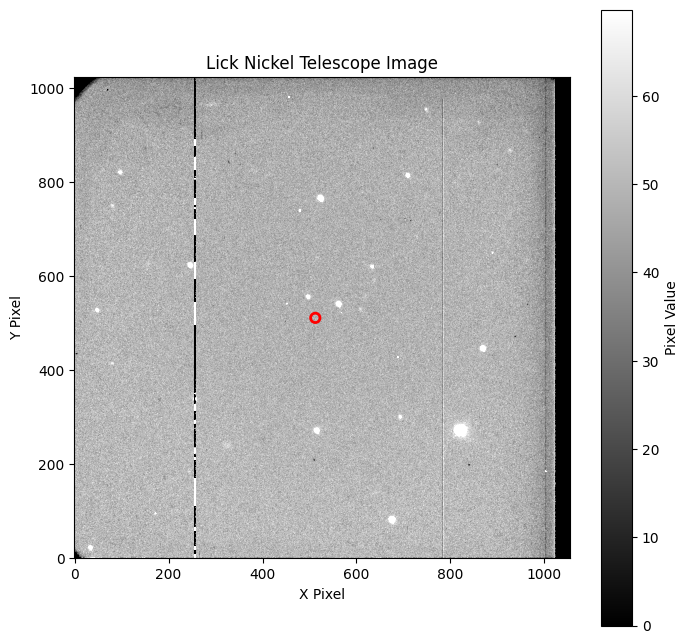

In [101]:

# Load the image data from the FITS file
image_data, header = fits.getdata('../data/reduced/d4082.fits', header=True)

# Create a WCS object
wcs = WCS(header)


# Step 3: Define the coordinates of the object of interest (RA, DEC)
ra_object = '01:36:55.46'  # Right Ascension
dec_object = '+07:16:29.3'  # Declination

# Convert celestial coordinates to pixel coordinates
x_object, y_object = wcs.all_world2pix(ra_dec[0], ra_dec[1], 0)  # 0 for the first frame


# Create a basic image plot
plt.figure(figsize=(8, 8))
plt.imshow(image_data, cmap='gray', origin='lower', vmin=0, vmax=np.percentile(image_data, 99))
# Plot the thin red circle
circle_radius = 10  # Adjust the radius for the circle
circle = plt.Circle((x_object, y_object), circle_radius, color='red', fill=False, linewidth=2)
plt.gca().add_artist(circle)
plt.colorbar(label='Pixel Value')
plt.title('Lick Nickel Telescope Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()


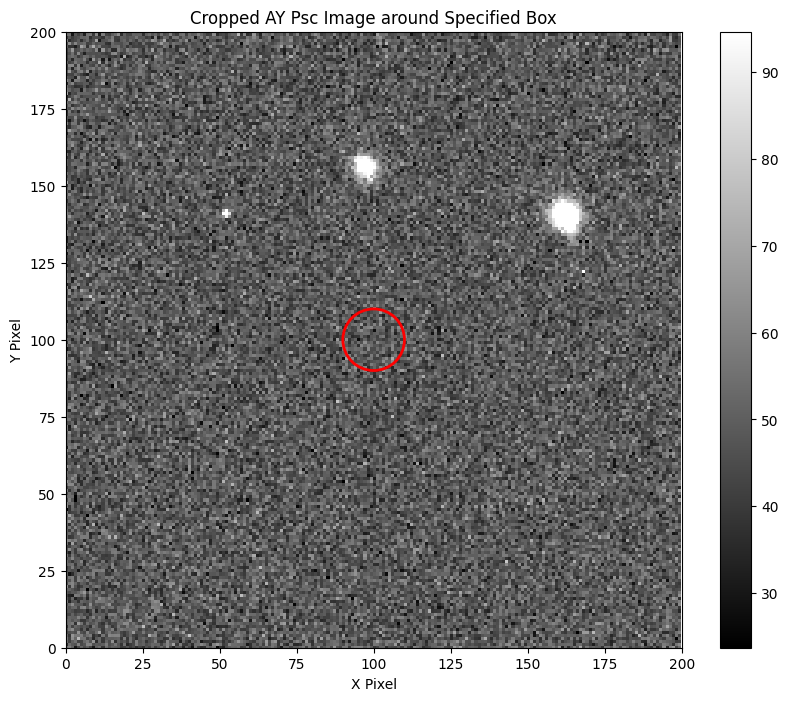

In [103]:
# Specify the crop ranges (adjust these as needed)
x_start, x_end = 400, 600
y_start, y_end = 400, 600

# Ensure crop boundaries are within the image limits
x_start = max(x_start, 0)
x_end = min(x_end, image_data.shape[1])
y_start = max(y_start, 0)
y_end = min(y_end, image_data.shape[0])

# Crop the image data
cropped_image = image_data[y_start:y_end, x_start:x_end]

# Use ZScale to find optimal vmin and vmax for the cropped image
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(cropped_image)

# Display the cropped image
plt.figure(figsize=(10, 8))
plt.imshow(cropped_image, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar()

# Plot the thin red circle at the center of the cropped image
circle_radius = 10  # Adjust the radius for the circle
circle = plt.Circle(((x_start + x_end) / 2 - x_start, (y_start + y_end) / 2 - y_start), 
                     circle_radius, color='red', fill=False, linewidth=2)
plt.gca().add_artist(circle)

plt.title('Cropped AY Psc Image around Specified Box')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.xlim(0, x_end - x_start)
plt.ylim(0, y_end - y_start)
plt.gca().set_aspect('equal', adjustable='box')  # Maintain aspect ratio
plt.show()

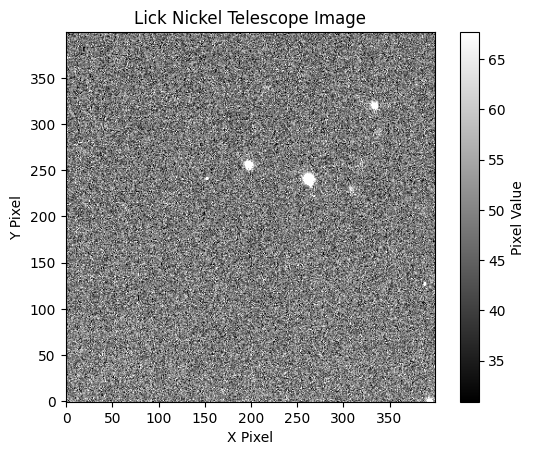

In [90]:

# Load the image data from the FITS file
image_data = fits.getdata('../data/reduced/d4082.fits')

x1, x2 = 300, 700  # Define the x-axis crop range
y1, y2 = 300, 700  # Define the y-axis crop range
cropped_image = image_data[y1:y2, x1:x2]

# Adjust vmin and vmax manually (e.g., 1% and 99% percentiles)
vmin = np.percentile(cropped_image, 1)   # Set to 1st percentile
vmax = np.percentile(cropped_image, 99)  # Set to 99th percentile

# Display the image with adjusted vmin and vmax
plt.imshow(cropped_image, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar(label='Pixel Value')
plt.title('Lick Nickel Telescope Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()



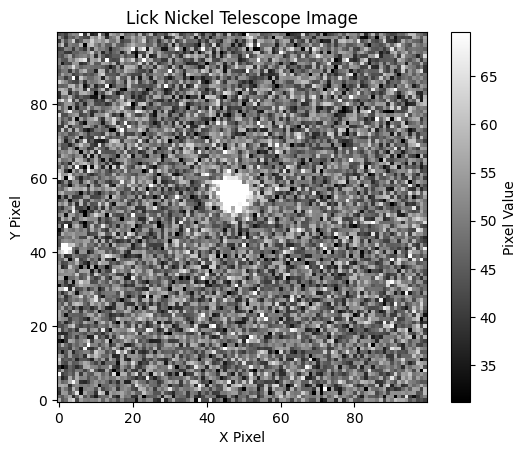

In [92]:

# Load the image data from the FITS file
image_data = fits.getdata('../data/reduced/d4082.fits')

x1, x2 = 450, 550  # Define the x-axis crop range
y1, y2 = 500, 600  # Define the y-axis crop range
cropped_image = image_data[y1:y2, x1:x2]

# Adjust vmin and vmax manually (e.g., 1% and 99% percentiles)
vmin = np.percentile(cropped_image, 1)   # Set to 1st percentile
vmax = np.percentile(cropped_image, 99)  # Set to 99th percentile

# Display the image with adjusted vmin and vmax
plt.imshow(cropped_image, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
plt.colorbar(label='Pixel Value')
plt.title('Lick Nickel Telescope Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()



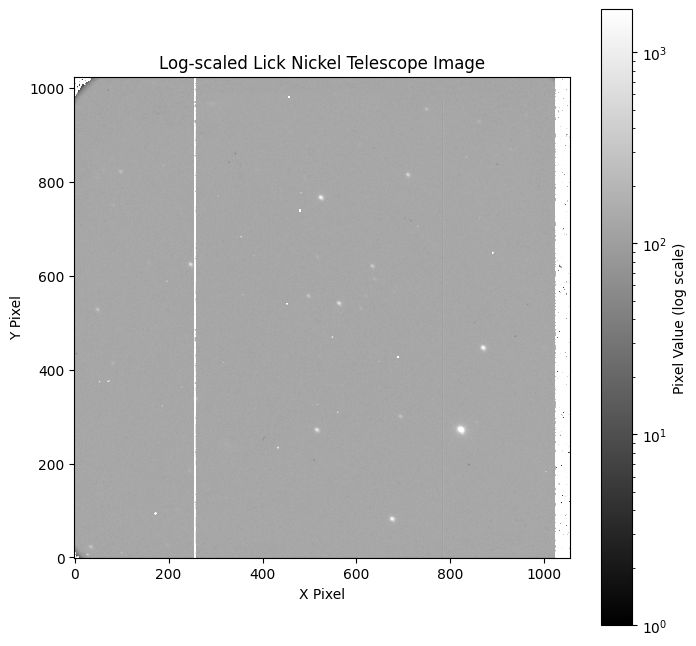

In [38]:
from matplotlib.colors import LogNorm

# Use Logarithmic scaling
plt.figure(figsize=(8, 8))
plt.imshow(image_data, cmap='gray', origin='lower', norm=LogNorm(vmin=1, vmax=np.percentile(image_data, 99)))
plt.colorbar(label='Pixel Value (log scale)')
plt.title('Log-scaled Lick Nickel Telescope Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()


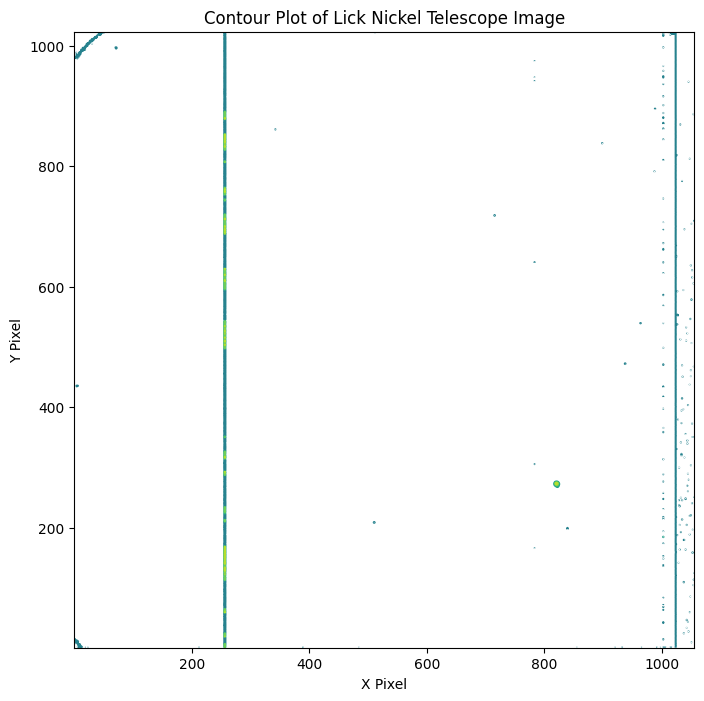

In [104]:
plt.figure(figsize=(8, 8))
plt.contour(image_data, levels=10, cmap='viridis', origin='lower')
plt.title('Contour Plot of Lick Nickel Telescope Image')
plt.xlabel('X Pixel')
plt.ylabel('Y Pixel')
plt.show()
